In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import metrics

import matplotlib.pyplot as plt

FOLDER_PATH = '../../../Datasets/Evaluations/Schema Matching/Error_Analysis/Confidence Analysis/'


In [3]:
import os
import csv

def import_csv_files(folder_path):
    # List all files in the folder
    files = os.listdir(folder_path)
    
    # Filter only CSV files
    csv_files = [file for file in files if file.endswith('.csv')]
    file_paths = []
    # Loop through each CSV file and import its data
    for csv_file in csv_files:
        file_paths.append(os.path.join(folder_path, csv_file))

    csv_files_stripped = [file[:-4] for file in csv_files]
    return file_paths, csv_files_stripped

# Example usage:
file_paths, csv_files = import_csv_files(FOLDER_PATH)




gpt-3.5-turbo_confidence_dynamic_fewshot_multi_table_gpt-4-turbo-preview :
          mean       std       var
kind                              
FN    0.079730  0.228357  0.052147
FP    0.950000  0.057735  0.003333
TN    0.120163  0.264218  0.069811
TP    0.940476  0.058683  0.003444
overall:
mean    0.200778
std     0.352314
var     0.124125
Name: analysis_value, dtype: float64





/var/folders/pw/9fnphybj4kq8t6wt3h592_9r0000gn/T/ipykernel_12083/1027286182.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_data['y_true'] = df_data['y_true'].replace(False, 0)
/var/folders/pw/9fnphybj4kq8t6wt3h592_9r0000gn/T/ipykernel_12083/1027286182.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_data['y_pred'] = df_data['y_pred'].replace(False, 0)


gpt-3.5-turbo_confidence_zero_shot_multi_table_gpt-4-turbo-preview :
          mean       std       var
kind                              
FN    0.282653  0.437982  0.191828
FP    0.925000  0.095743  0.009167
TN    0.360627  0.455097  0.207114
TP    0.936667  0.071840  0.005161
overall:
mean    0.395556
std     0.462794
var     0.214178
Name: analysis_value, dtype: float64



gpt-3.5-turbo_confidence_fix_fewshot_multi_table_gpt-4-turbo-preview :
          mean       std       var
kind                              
FN    0.142500  0.295164  0.087122
FP    0.940000  0.054772  0.003000
TN    0.127869  0.258953  0.067057
TP    0.938462  0.049286  0.002429
overall:
mean    0.208444
std     0.346757
var     0.120240
Name: analysis_value, dtype: float64





/var/folders/pw/9fnphybj4kq8t6wt3h592_9r0000gn/T/ipykernel_12083/1027286182.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_data['y_true'] = df_data['y_true'].replace(False, 0)
/var/folders/pw/9fnphybj4kq8t6wt3h592_9r0000gn/T/ipykernel_12083/1027286182.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_data['y_pred'] = df_data['y_pred'].replace(False, 0)
/var/folders/pw/9fnphybj4kq8t6wt3h592_9r0000gn/T/ipykernel_12083/1027286182.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed 

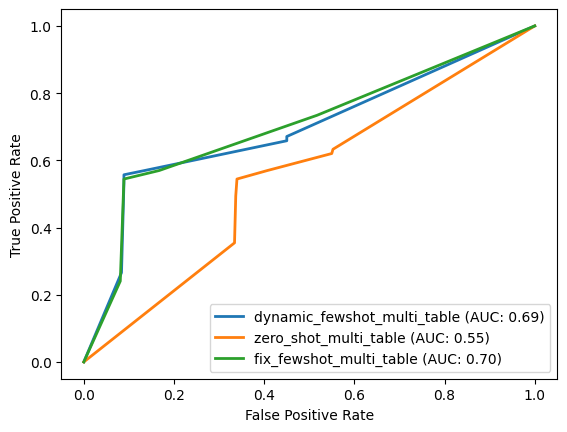

In [8]:
def extract_confidence(value):
    return float(value.split(':')[1].strip().replace('%', ''))

def classify_row(row):
    if row['y_true'] == 1 and row['y_pred'] == 1:
        return 'TP'  # True Positive
    elif row['y_true'] == 0 and row['y_pred'] == 1:
        return 'FP'  # False Positive
    elif row['y_true'] == 0 and row['y_pred'] == 0:
        return 'TN'  # True Negative
    elif row['y_true'] == 1 and row['y_pred'] == 0:
        return 'FN'  # False Negative

for i in range(len(file_paths)):
    df_data = pd.read_csv(file_paths[i])
    print(csv_files[i], ":")
    df_data['y_true'] = df_data['y_true'].replace(True, 1)
    df_data['y_true'] = df_data['y_true'].replace(False, 0)

    df_data['y_pred'] = df_data['y_pred'].replace(True, 1)
    df_data['y_pred'] = df_data['y_pred'].replace(False, 0)

    df_data['kind'] = df_data.apply(classify_row, axis=1)
    df_data['analysis_value'] = df_data['confidence'].apply(extract_confidence)
    df_data.loc[df_data['y_pred'] == 0, 'analysis_value'] = 100 - df_data.loc[df_data['y_pred'] == 0, 'analysis_value']
    df_data['analysis_value'] = df_data['analysis_value'] / 100

    result = df_data.groupby('kind')['analysis_value'].agg(['mean', 'std', 'var'])
    result2 = df_data['analysis_value'].agg(['mean', 'std', 'var'])
    #print(df_data.head())

    print(result)
    print("overall:")
    print(result2)
    print()

    fpr, tpr, _ = metrics.roc_curve(df_data['y_true'],  df_data['analysis_value'])
    auc = metrics.roc_auc_score(df_data['y_true'], df_data['analysis_value'])
    plt.plot(fpr, tpr, lw=2, label=f'{df_data['prompt_name'][0]} (AUC: {auc:.2f})')
    plt.legend(loc="lower right")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')


    print("\n")
plt.show()
